In [1]:
import sys
sys.path.append("..")
from modules.utils import generate_matrix_close_to_isometry, generate_matrix_far_from_isometry, isometry_gap, ortho_gap
from modules.models import MLPWithBatchNorm, SinAct, CustomNormalization
from torch import nn
import torch
from torch.func import jacfwd
from tqdm import tqdm
import pandas as pd
import numpy as np
import math
import matplotlib
import itertools
from constants import *
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms, datasets
matplotlib.rcParams["figure.dpi"] = 80
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
sns.set(rc={"figure.dpi":80, 'savefig.dpi':80})
sns.set_theme()
sns.set_context('paper')
palette = sns.color_palette("tab10")
style = {"grid.linestyle": ":", 
        "border.color": "black",
       "axes.edgecolor": "black",
       "xtick.bottom": "True",
       "xtick.top": "True",
       "ytick.left": "True",
       "ytick.right": "True",
       "xtick.direction": "in",
       "ytick.direction": "in"}

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor()])

d = 100
n = 100

root_dir = 'data'
train_set = datasets.MNIST(root=root_dir, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=n, shuffle=True)
test_x, test_y = next(iter(train_loader))
test_x = test_x.flatten(1, -1)
test_y = test_y

In [3]:
inits = ['orthogonal', 'xavier_normal']
act_names = ['identity']

# act_names = ['identity', 'tanh', 'sin'] # for nonlinearities, enable them here. see full list in ACTIVATIONS

depths = [5, 10, 20, 50, 100, 200, 500, 1000]
runs = list(itertools.product(*[inits, act_names, depths]))

In [4]:
df = []
for run in tqdm(runs):
    init_type, act_name, L = run
    for expi in range(10):
        activation = ACTIVATIONS[act_name]
        model = MLPWithBatchNorm(input_dim=1*28*28, 
                                output_dim=10, 
                                num_layers=L, 
                                hidden_dim=d, 
                                norm_type='bn',
                                bias=False,
                                order='norm_act',
                                force_factor=None,
                                mean_reduction=False,
                                activation=activation,
                                exponent=0,
                                save_hidden=True)

        model.reset_parameters(init_type, gain=GAINS[act_name])

        criterion = nn.CrossEntropyLoss()
        model.zero_grad()
        y_pred = model(test_x)
        outputs = model.hiddens
        loss = criterion(y_pred, test_y)
        loss.backward()
        df.append({
            'grad': model.layers[f'fc_1'].weight.grad.norm().log().item(),
            'isogap': isometry_gap(outputs[f'fc_{L-1}']).item(),
            'Activation': act_name,
            'Initialization': init_type,
            'Depth': L
            })
df = pd.DataFrame(df)

100%|██████████| 16/16 [00:34<00:00,  2.17s/it]


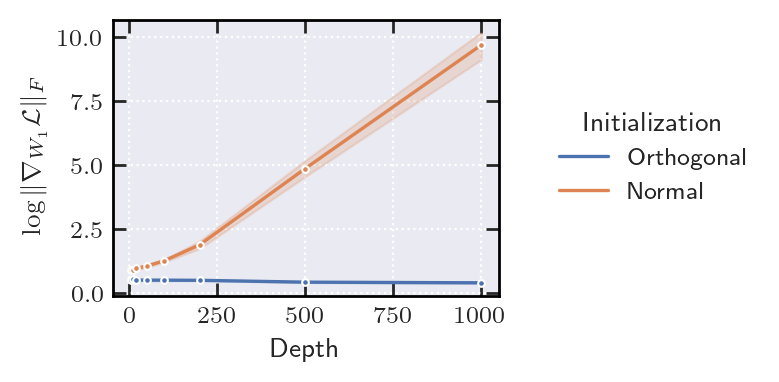

In [5]:
from IPython.display import IFrame
edited_df = df.replace('orthogonal','Orthogonal').replace('xavier_normal', 'Normal')
edited_df = edited_df[edited_df['Activation'] == 'identity']
sns.set_style('darkgrid', style)
fig, ax = plt.subplots(dpi=200, figsize=(4,2), ncols=1)
sns.lineplot(edited_df, x='Depth', y='grad', hue='Initialization', ax=ax, legend='full', marker='.')
ax.set_ylabel(r'$\log \| \nabla_{W_1} \mathcal{L} \|_F$')
ax.legend(frameon=False, title='Initialization')
sns.move_legend(ax, "center left", bbox_to_anchor=(1.1, 0.5))
fig.tight_layout()


img_name = "gradients.pdf"
fig.savefig('images/'+img_name)



# Mean reduction effect

In [6]:
inits = ['orthogonal']
act_names = ['identity']
mrs = [True, False]
depths = [5, 10, 20, 50, 100, 200, 500, 1000]

runs = list(itertools.product(*[inits, act_names, depths, mrs]))

In [7]:
df = []
for run in tqdm(runs):
    init_type, act_name, L, mr = run
    force_factor = None if mr is True else 1.0
    for expi in range(10):
        activation = ACTIVATIONS[act_name]
        model = MLPWithBatchNorm(input_dim=1*28*28, 
                                output_dim=10, 
                                num_layers=L, 
                                hidden_dim=d, 
                                norm_type='bn',
                                bias=False,
                                order='norm_act',
                                force_factor=force_factor,
                                mean_reduction=mr,
                                activation=activation,
                                exponent=0,
                                save_hidden=True)

        model.reset_parameters(init_type, gain=GAINS[act_name])
        criterion = nn.CrossEntropyLoss()
        model.zero_grad()
        y_pred = model(test_x)
        outputs = model.hiddens
        loss = criterion(y_pred, test_y)
        loss.backward()
        

        norm_type2 = 'Without' if mr==False else 'With' 
        grad = model.layers[f'fc_{0}'].weight.grad.norm().log().item()
        df.append({
            'grad': grad,
            'Activation': act_name,
            'Initialization': init_type,
            'Depth': L,
            'norm_type': norm_type2
            })
df = pd.DataFrame(df)

100%|██████████| 16/16 [00:47<00:00,  2.99s/it]


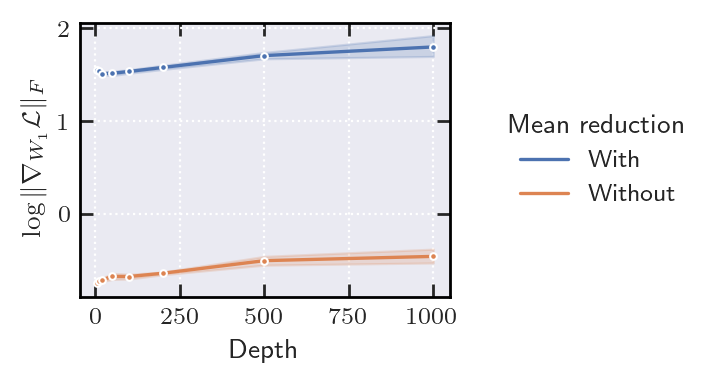

In [8]:
sns.set_style('darkgrid', style)
fig, ax = plt.subplots(dpi=200, ncols=1, figsize=(4, 2))
sns.lineplot(df, x='Depth', y='grad', ax=ax, hue='norm_type', legend='full', marker='.')
ax.legend(frameon=False, title='Mean reduction')
sns.move_legend(ax, "center left", bbox_to_anchor=(1.1, 0.5))
ax.set_ylabel(r'$\log \| \nabla_{W_1} \mathcal{L} \|_F$')
fig.tight_layout()

# img_name = "MeanReductionEffect.pdf"
# fig.savefig('images/'+img_name)
